## Enunciado

Neste notebook temos um problema clássico de Ciência de Dados, precisamos descobrir o preço do milho em um conjunto de cidades do Brasil. Contudo temos um problema sério, a única informação que temos hoje é a posição da cidade e o preço histórico dela, nossa modelagem não poderá se utilizar do preço atual, você ficará livre para propor fontes de informações que possam ser úteis na descoberta do preço do milho.

O notebook já está estruturado no formato padrão, algumas células estarão vazias e com um comentário do é esperado que seja feito naquele trecho. 

Você tem total liberdade de adicionar nova células e criar novas ideias para o seu código, peço somente que mantenha as partes do código que já estão escritas pois elas servem para guiar o formato final do notebook

Não se preocupe, caso alguma parte não funciona, pode adicionar um comentário ou alguma observação de qual foi o problema enferentado, mas lembre-se de sempre detalhar o seu pensamento, ele vale mais do que uma sintaxe errada no código!

Boa Sorte!

In [2]:
# Bibliotecas

import pandas as pd
import math
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Leitura dos dados originais

df = pd.read_csv('Data/real_prices.csv', index_col = 0) # Adicionei um index_col aqui porque o csv tem uma coluna com os índices

# O lgb tá dando problema com algumas colunas com caracteres especiais, então eu também fiz um regex pra resolver isso
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

df.head()

,city_id,reference_date,price_per_unit
0,4104907,2021-04-27,102
1,5205471,2021-04-27,79
2,5002951,2021-04-27,105
3,4204202,2021-04-27,64
4,4204301,2021-04-27,86


No primeiro momento nós precisamos definir quais serão as novas fontes de dados, para isso fica a cargo de você escolher se utilizará outras fontes de dados, ou se podemos seguir somente com as iniciais.

Caso decida por adicionar novas informações basta seguir o código a seguir que demonstra como adicionar novas informação ao DF original

In [4]:
locations = pd.read_csv('Data/cities_location.csv')

df = df.merge(locations, left_on=['city_id'], right_on=['id'], how='left')
df = df.drop(columns=['id'])

### Nova Fonte - Indicador do Milho Esalq/B3

Fonte: CEPEA

https://www.cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx

Temos uma grande vantagem utilizando essa fonte de dados: 
Além do nosso conjunto de dados ganhar uma informação importante para que possa aprender o quanto o preço do milho varia de acordo com a localização da cidade, esse indicador também já reflete a cotação da moeda, então não precisamos nos preocupar com a normalização do preço devido à inflação.

In [5]:
b3_prices = pd.read_csv('Data/cepea_consulta.csv')
b3_prices['date'] = b3_prices['date'].apply(lambda x: (x[-4:]+"-"+x[3:5]+"-"+x[:2])) # Transformando as datas para o mesmo formato
b3_prices['b3_price']     = b3_prices['b3_price'].apply(lambda x: float(x.replace(',','.'))) # Transformando o tipo do dado dos preços de string pra int
b3_prices['b3_price_dol'] = b3_prices['b3_price_dol'].apply(lambda x: float(x.replace(',','.'))) # Transformando o tipo do dado dos preços de string pra int
b3_prices.head()

,date,b3_price,b3_price_dol
0,2021-04-27,98.88,18.09
1,2021-04-28,99.25,18.50
2,2021-04-29,99.78,18.64
3,2021-04-30,99.76,18.36
4,2021-05-03,99.84,18.41


In [6]:
df = df.merge(b3_prices, left_on=['reference_date'], right_on=['date'], how='left')
df = df.drop(columns=['date'])
df.head()

,city_id,reference_date,price_per_unit,latitude,longitude,b3_price,b3_price_dol
0,4104907,2021-04-27,102,-24.79,-50.01,98.88,18.09
1,5205471,2021-04-27,79,-18.40,-52.54,98.88,18.09
2,5002951,2021-04-27,105,-18.79,-52.62,98.88,18.09
3,4204202,2021-04-27,64,-27.09,-52.61,98.88,18.09
4,4204301,2021-04-27,86,-27.23,-52.02,98.88,18.09


Precisamos dividir o DF entre o que será meu treino e o que será meu teste, assim cabe a você definir como dividir esse dado entre treino e teste, qual o conjunto será utilizado para treino e qual será utilizado para teste (lembrando que a mesma cidade aparece várias vezes, já que temos vários dias)

In [7]:
# Vamos usar os dados até certa data como o treino e após certa data como o teste
# dessa forma, simulamos a situação em que estaríamos realmente utilizando nosso modelo.

# Iremos escolher uma data de forma que o nosso treino-teste fique com uma divisão de aproximadamente 90% pro treino e 10% pro teste
split_date = sorted(df['reference_date'])[math.floor(len(df) * 0.9)]
# Agora fazemos um vetor de bool que nos indica quem pertence a treino e quem pertence à teste
train_entries = [True if df['reference_date'][i] <= split_date else False for i in range(len(df))]
    
df_train = df.iloc[train_entries]
df_test  = df.iloc[[not x for x in train_entries]].reset_index()
df_test  = df_test.drop(columns=['index'])

Por fim separamos o target do conjunto de entrada, para isso basta selecionar a coluna que servirá de target no Y e remover a mesma do X

In [8]:
# Coloque o nome da coluna na variável abaixo

target_col = 'price_per_unit'
y = df_train[target_col]
X = df_train.drop(['city_id', 'reference_date', target_col], axis=1)

# Cria modelo
lgbm_model = lgb.LGBMRegressor()
lgbm_model.fit(X, y)

# Predição
y_test = df_test[target_col]
X_test = df_test.drop(['city_id', 'reference_date', target_col], axis=1)
predicted = lgbm_model.predict(X_test)

# Calcula erro
lgbm_mae  = mean_absolute_error(y_test, predicted)
lgbm_rmse = mean_squared_error(y_test, predicted, squared=False)

print("MAE =", lgbm_mae)
print("RMSE =", lgbm_rmse)

MAE = 11.595506554099556
RMSE = 13.418673499184356


Fique a vontade para adicionar novas células com mais conteúdos da sua preferência a partir daqui, caso tenha algum insight interessante que ficaria fora da estrutura original basta adicionar e comentar

O erro não parece nada bom e após tentar algumas outras técnicas eu comecei a pensar na hipótese de que talvez esses dados não sejam tão bem comportados assim. Então eu resolvi plotar eles em uma grid tridimensional para dar uma olhada no formato.

In [12]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

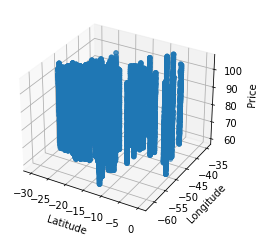

In [19]:
plot = plt.figure().gca(projection='3d')
plot.scatter(df['latitude'], df['longitude'], df['price_per_unit'])
plot.set_xlabel('Latitude')
plot.set_ylabel('Longitude')
plot.set_zlabel('Price')
plt.show()

Com essa figura dá para perceber que não existe um agrupamento claro dos preços devido a latitude e longitude. Na verdade a distribuição dos preços aparenta até ser uniforme, com os valores variando uniformemente entre 60 e 100. Vamos dar uma olhada em como a média dos preços variou em relação ao preço da B3.

In [29]:
date_df = df.groupby('reference_date').mean()
x  = date_df.index
y1 = date_df['price_per_unit']
y2 = date_df['b3_price']

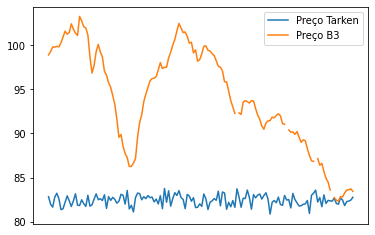

In [45]:
plt.xticks([])
plt.plot(x, y1, label = "Preço Tarken")
plt.plot(x, y2, label = "Preço B3")
plt.legend(loc = 'best')
plt.show()

Acho que fica claro que, apesar de o preço do milho na B3 ter variado bastante, ele segue uma distrubuição muito mais bem comportada do que a da média dos preços que foram passados. Vamos comparar agora a distribuição dos preços que foram passados com uma média de distribuições de probabilidade uniforme entre 60 e 100.

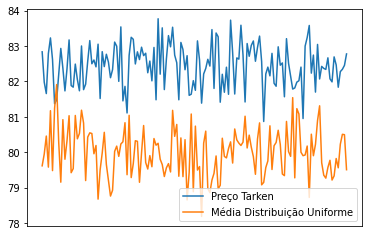

In [65]:
n_cities = len(pd.unique(df['city_id']))
yrandom  = []
for i in range(len(y1)):
    value = 0
    for j in range(n_cities):
        value += np.random.uniform(60, 100)
    yrandom.append(value/n_cities)
    
plt.xticks([])
plt.plot(x, y1, label      = "Preço Tarken")
plt.plot(x, yrandom, label = "Média Distribuição Uniforme")
plt.legend(loc = 'best')
plt.show()

Acho que descobrimos com o que estamos lidando né :)))

Adorei o desafio, foi divertido quebrar a cabeça até entender o que estava acontecendo kkkkkk

Espero ter desvendado o mistério corretamente.